### RNN with Attention (Possible solution)

In [1]:
# -*- coding: utf-8 -*-
"""
Wind Turbine Power Prediction with RNNs + Attention

This lab uses an Attention-enhanced Recurrent Neural Network to predict wind turbine power output.
"""

# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

df = pd.read_csv('T1.csv')

# Step 1: Prepare the Data
df['Date Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M') # creating new field in datetime format
df = df.drop('Date/Time', axis=1) # dropping original datetime field
df.set_index('Date Time', inplace=True) # setting the datetime field as the index
df.head() # verifying reindexing

df2 = df.drop('Theoretical_Power_Curve (KWh)', axis=1) # dropping theoretical curve in favor of keeping observed data only
data = df2.values
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))


In [2]:
# Step 2: Create sequences

seq_size = 36 # creating 6 hour windows (6 observations per hour x 6 hours)

X = []
y = []

for i in range(seq_size, len(df)):
    X.append(data[i-seq_size:i, 0])
    y.append(data[i, 0])

X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape, y.shape

((50494, 36, 1), (50494,))

In [3]:
# Step 3: Split the data
train_size = int(len(X) * 0.8) # 80 / 20 train / test split

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40395, 36, 1), (40395,), (10099, 36, 1), (10099,))

In [4]:
# Step 4: Define a Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create trainable weights for computing attention scores
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute alignment scores using tanh activation
        score = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        # Normalize scores to get attention weights
        attention_weights = tf.nn.softmax(score, axis=1)
        # Compute the context vector as a weighted sum of inputs
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


In [34]:
# Step 5: Build the RNN Model with Attention
# define the input layer 
input_seq = Input(shape=(seq_size, 1))
# LSTM layer that outputs the full sequence
lstm_out1 = LSTM(100, return_sequences=True)(input_seq)
# custom attention layer
context_vector, attention_weights = AttentionLayer()(lstm_out1)
# 2nd LSTM layer
lstm_out2 = LSTM(50, return_sequences=True)(lstm_out1)
context_vector, attention_weights = AttentionLayer()(lstm_out2)
# dense layer for regression
output = Dense(1, activation='linear')(context_vector)
# Create the model
model = Model(inputs=input_seq, outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 36, 1)]           0         
                                                                 
 lstm_12 (LSTM)              (None, 36, 100)           40800     
                                                                 
 lstm_13 (LSTM)              (None, 36, 50)            30200     
                                                                 
 attention_layer_13 (Attenti  ((None, 50),             2550      
 onLayer)                     (None, 36, 50))                    
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 73,601
Trainable params: 73,601
Non-trainable params: 0
_______________________________________________________

In [35]:
# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Number of epochs with no improvement after which to stop
    min_delta=0.0005,          # Minimum change to qualify as improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value
)

# model checkpoint
checkpoint_filepath = './best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,      # Only save when there's improvement
    mode='min',               # The direction is 'min' for loss
    verbose=1                 # Show progress
)

callbacks = [
    early_stopping,
    model_checkpoint
]

In [36]:
# Step 6: Compile and Train the Model
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)

Epoch 1/50
1262/1263 [============================>.] - ETA: 0s - loss: 0.0545
Epoch 1: val_loss improved from inf to 0.01536, saving model to .\best_model.keras
1263/1263 [==============================] - 46s 35ms/step - loss: 0.0545 - val_loss: 0.0154
Epoch 2/50
1262/1263 [============================>.] - ETA: 0s - loss: 0.0167
Epoch 2: val_loss improved from 0.01536 to 0.00835, saving model to .\best_model.keras
1263/1263 [==============================] - 45s 36ms/step - loss: 0.0167 - val_loss: 0.0083
Epoch 3/50
1262/1263 [============================>.] - ETA: 0s - loss: 0.0135
Epoch 3: val_loss improved from 0.00835 to 0.00622, saving model to .\best_model.keras
1263/1263 [==============================] - 46s 37ms/step - loss: 0.0135 - val_loss: 0.0062
Epoch 4/50
1262/1263 [============================>.] - ETA: 0s - loss: 0.0095
Epoch 4: val_loss improved from 0.00622 to 0.00589, saving model to .\best_model.keras
1263/1263 [==============================] - 47s 37ms/step - 

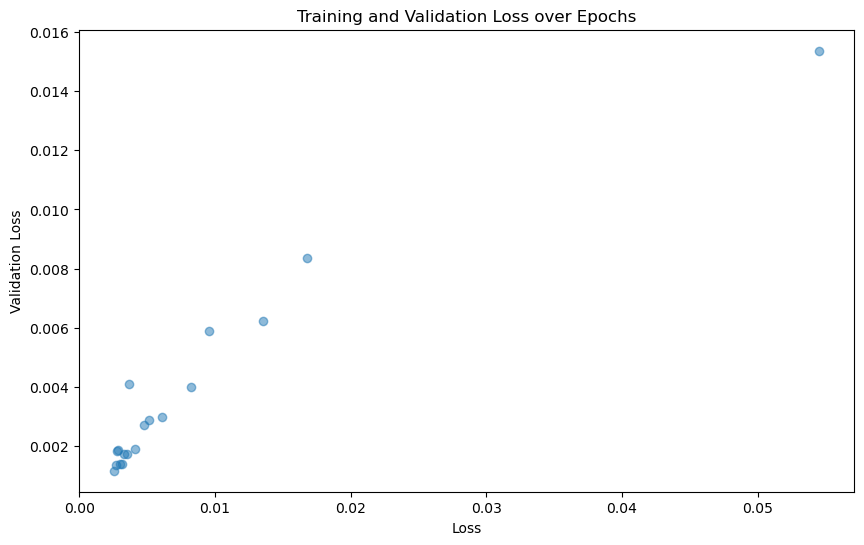

In [37]:
# training and validation loss curves
plt.figure(figsize=(10, 6))
plt.scatter(history.history['loss'], history.history['val_loss'], alpha=0.5)
plt.xlabel('Loss')
plt.ylabel('Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [38]:
# Step 7: Evaluate and Visualize
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_inv.shape, y_pred_inv.shape

316/316 [==============================] - 4s 12ms/step


((10099, 1), (10099, 1))

In [39]:
# mse, rmse, and r2
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-Squared: {r2:.4f}")

Mean Squared Error: 18515.4001
Root Mean Squared Error: 136.0713
R-Squared: 0.9681


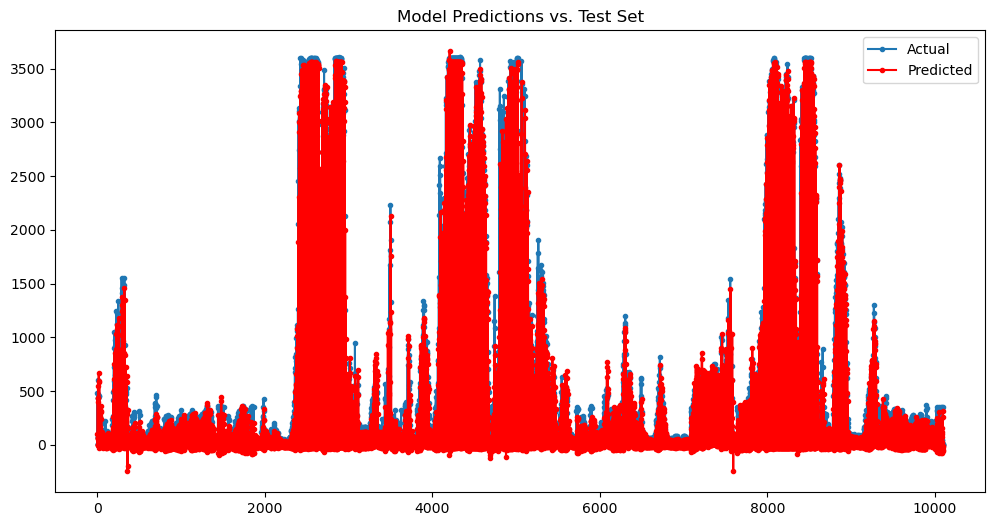

In [40]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv.flatten(), marker='.', label="Actual")
plt.plot(y_pred_inv.flatten(), 'r', marker='.', label="Predicted")
plt.legend()
plt.title('Model Predictions vs. Test Set')
plt.show()

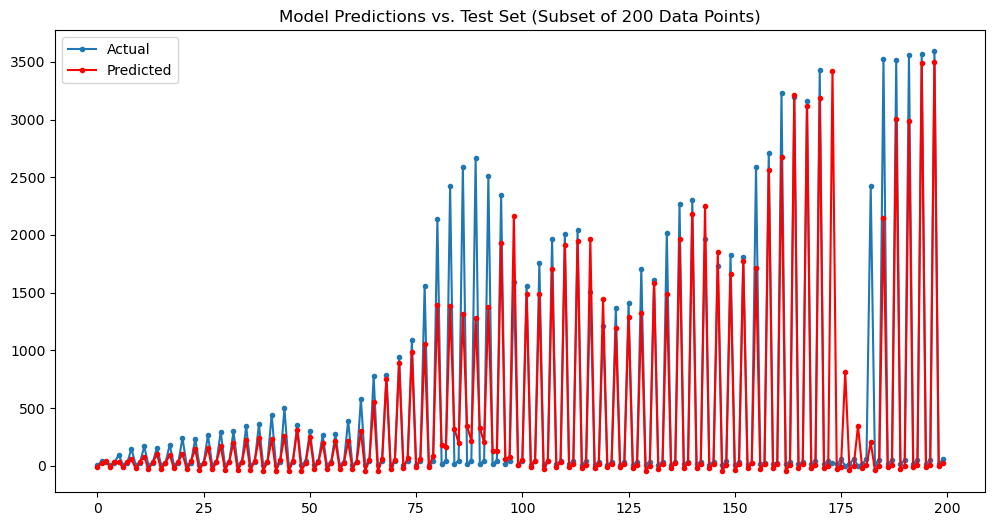

In [41]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv.flatten()[4000:4200], marker='.', label="Actual")
plt.plot(y_pred_inv.flatten()[4000:4200], 'r', marker='.', label="Predicted")
plt.legend()
plt.title('Model Predictions vs. Test Set (Subset of 200 Data Points)')
plt.show()

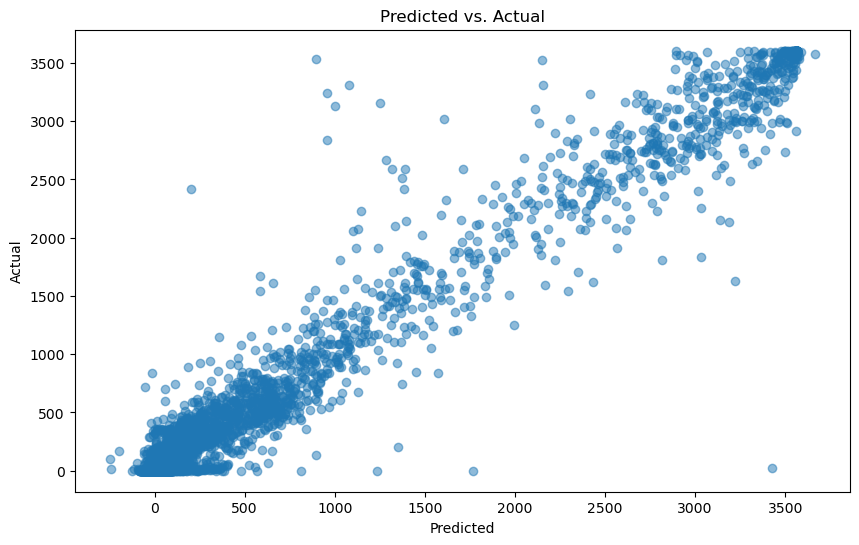

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_inv.flatten(), y_test_inv.flatten(), alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual')
plt.show()

**Note:** I experimented with a variety of model configurations, including 1, 2, and 3 LSTM layers and a wide variety of neurons per layer (20-120). This model has the best R-squared, among the best MSE/RSME scores, and best fits the actual data in the 3 charts above.